In [151]:
import copy
from   random import choice
import math 

import numpy as np
from   sklearn.cluster import HDBSCAN, DBSCAN
import hdbscan

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import NaiveDE
import SpatialDE
import pandas as pd

import networkx as nx

from plot import *
from data import *
from filt import *
from filt import ITNI, ITSNI, VNI

from scipy.optimize import minimize
from scipy.stats import nbinom

def negative_log_likelihood(params, data):
    r, p = params
    if r <= 1e-5 or p <= 0 or p >= 1:
        return np.inf  
    
    nll = -np.sum(np.log(nbinom(r, p).pmf(data)))
    return nll

def aux_fit_binom(data, method):
    initial_guess = [1, 0.5]

    result = minimize(
                negative_log_likelihood, 
                initial_guess, 
                args   = (data,), 
                method = method, 
                bounds = [(1e-5, None), (1e-5, 1-1e-5)])

    n, p = result.x
    return n, p

def fit_nbinom(data, iter=1, method="L-BFGS-B"):

    n, p = 0, 0

    for i in range(iter):
        ni, pi = aux_fit_binom(data, method)
        n += ni
        p += pi

    return n/iter, p/iter

In [2]:
W  = '#efefd0'
B  = '#004e89'
Or = "#ff6b35"
mpl.rcParams['text.color']       = B
mpl.rcParams['axes.labelcolor']  = W
mpl.rcParams['axes.edgecolor']   = W
mpl.rcParams['axes.facecolor']   = W
mpl.rcParams['figure.facecolor'] = W
mpl.rcParams['xtick.color']      = W
mpl.rcParams['ytick.color']      = W
mpl.rcParams['font.family']      = "monospace"

colors    = [B, Or]
cmap_name = "balck_yellow"
myCMAP    = LinearSegmentedColormap.from_list(cmap_name, colors)


In [17]:
scdata     = load_data()
array_data = scdata.X.toarray().T

### map from index of spot to cartesian coordinates
index_to_cart = np.zeros((len(scdata.obs), 2))
max_row       = scdata.obs['array_row'].max()
for i, ind in enumerate(scdata.obs.index):
    col = scdata.obs['array_col'][ind]
    row = scdata.obs['array_row'][ind]
    index_to_cart[i, 0] = col             * (np.sqrt(3)/2)
    index_to_cart[i, 1] = (max_row - row) * (3/2)

# smallest = select_top_spatially_variable_genes(scdata, 3000, 1000, 3000)
# print(smallest.shape)

smallest = np.load("spatially_variable_genes.npy")
print(smallest.shape)

#array_data = array_data[smallest]

c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(3558,)


In [19]:
gene_names = scdata.var.index.to_numpy()

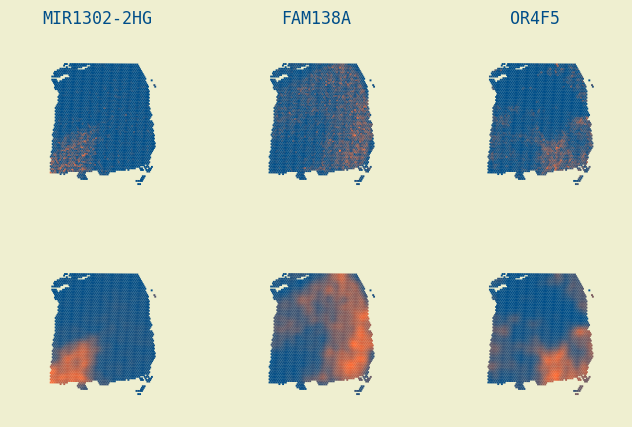

In [27]:
g_ids = [6546, 32600, 17855]

_, axs = plt.subplots(2, 3, figsize=(8, 5))

for i, gene_id in enumerate(g_ids):
    gdata   = get_gene_data(scdata, gene_id)

    plot_spatial_scatter(
        scdata, 
        gdata,  
        ax           = axs[0, i],
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square")
    
    axs[0, i].set_title(gene_names[i])
    
    gdata = opt_mean_filter_iterated(gdata, 5)

    plot_spatial_scatter(
        scdata, 
        gdata,  
        ax           = axs[1, i],
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square")

plt.savefig("presentazione\\mean_filter", dpi=1000, bbox_inches='tight')

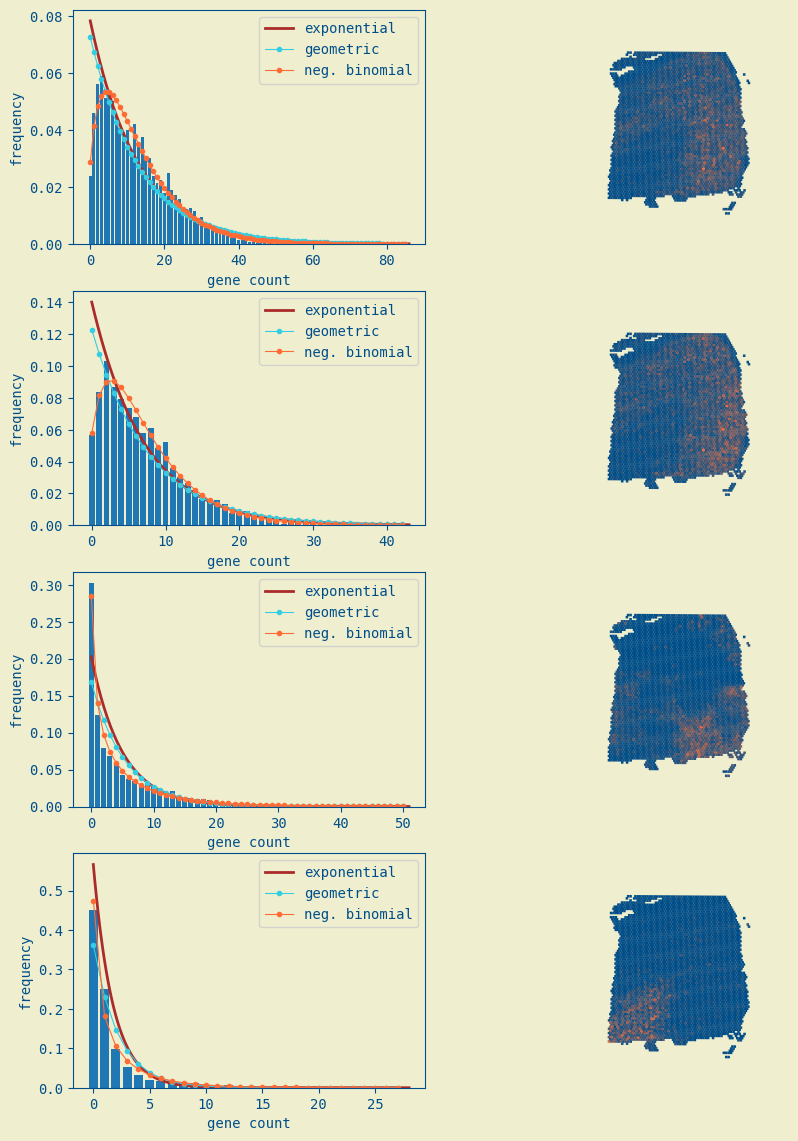

In [168]:
from scipy.stats import expon, geom

W  = '#efefd0'
B  = '#004e89'
Or = "#ff6b35"
mpl.rcParams['text.color']       = B
mpl.rcParams['axes.labelcolor']  = B
mpl.rcParams['axes.edgecolor']   = B
mpl.rcParams['axes.facecolor']   = W
mpl.rcParams['figure.facecolor'] = W
mpl.rcParams['xtick.color']      = B
mpl.rcParams['ytick.color']      = B
mpl.rcParams['font.family']      = "monospace"

_, axs = plt.subplots(4, 2, figsize=(10, 14))

for i, gene_id in enumerate([29313, 32600, 17855, 6546]):

    ax1, ax2 = axs[i]

    gdata   = get_gene_data(scdata, gene_id).astype(int)

    bins  = np.bincount(gdata)/len(gdata)
    count = np.arange(np.max(gdata)+1)

    ax1.bar(count, bins, width=0.8)
    ax1.set_ylabel("frequency")
    ax1.set_xlabel("gene count")

    expo_x   = np.linspace(0, gdata.max()+1, 200)
    expo_pdf = expon(scale=gdata.mean()).pdf(expo_x)
    ax1.plot(
        expo_x, 
        expo_pdf, 
        color = "#ab2b2b", 
        lw    = 2, 
        label = "exponential")

    p        = 1/(gdata.mean() + 1)
    geom_pdf = geom(p, loc=-1).pmf(count)
    ax1.plot(
        count, 
        geom_pdf, 
        color  = "#35cde2", 
        marker = "o", 
        ms     = 3, 
        lw     = 0.8,
        label  = "geometric")

    n, p     = fit_nbinom(gdata, iter=10, method="Nelder-Mead")
    nbin_pdf = nbinom(n, p).pmf(count)
    ax1.plot(
        count, 
        nbin_pdf, 
        color  = Or,  
        marker = "o", 
        ms     = 3, 
        lw     = 0.8, 
        label  = "neg. binomial")

    ax1.legend()

    plot_spatial_scatter(
        scdata, 
        gdata,  
        ax           = ax2,
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square")

plt.savefig("presentazione\\distributions", dpi=1000, bbox_inches="tight")
plt.show()


In [ ]:
scdata     = load_data()
smallest   = select_top_spatially_variable_genes(scdata, 3000, 500, 3000)
array_data = scdata.X.toarray().T[smallest]
ax1 = plt.gca()
smallest.shape

c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(1033,)

In [1328]:
spat_var_genes = np.load("spatially_variable_genes.npy")
array_data     = scdata.X.toarray().T[spat_var_genes]
array_data.shape

(3558, 3639)

In [ ]:
params = np.zeros((2, len(spat_var_genes)))

for i in range(len(spat_var_genes)):
    if i%100==0: print(i)
    
    gdata        = array_data[i].astype(int)
    params[:, i] = fit_nbinom(gdata, iter=1, method="L-BFGS-B")

In [1329]:
array_data.shape, params.shape

((3558, 3639), (2, 3558))

In [1377]:
LLs = np.zeros((len(spat_var_genes), 2))

for i in range(len(spat_var_genes)):

    gdata = array_data[i].astype(int)
    n, p  = params[:, i]

    nbin_LL = np.sum(np.log(nbinom(n, p).pmf(gdata)))
    #expo_LL = np.sum(np.log(expon(scale=gdata.mean()).pdf(gdata))) 
    geom_LL = np.sum(np.log(geom(1/(gdata.mean() + 1), loc=-1).pmf(gdata)))

    LLs[i] = [nbin_LL, geom_LL]

In [1376]:
np.bincount(np.argmax(LLs, axis=1))

array([3558], dtype=int64)

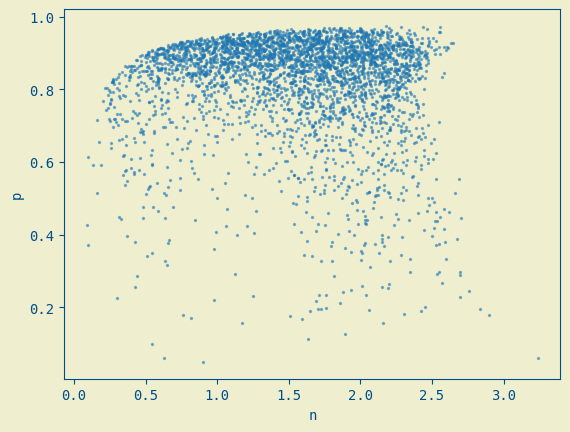

In [217]:
plt.scatter(params[0], params[1], s=2, alpha=0.5)
plt.ylabel("p")
plt.xlabel("n")
plt.savefig("presentazione\\nbinom_params_scatter", dpi=1000)
plt.show()

In [218]:
def plot_counts_and_scatter(gdata, axs):

    ax1, ax2 = axs

    plot_spatial_scatter(
        scdata, 
        np.sqrt(gdata),  
        ax           = ax2,
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square")

    bins  = np.bincount(gdata)/len(gdata)
    count = np.arange(np.max(gdata)+1)

    ax1.bar(count, bins, width=0.8)
    ax1.set_ylabel("frequency")
    ax1.set_xlabel("gene count")

    n, p     = fit_nbinom(gdata, iter=10, method="Nelder-Mead")
    nbin_pdf = nbinom(n, p).pmf(count)
    ax1.plot(
        count, 
        nbin_pdf, 
        color  = Or,  
        marker = "o", 
        ms     = 3, 
        lw     = 0.8, 
        label  = "neg. binomial")

In [ ]:
_, axs = plt.subplots(4, 2, figsize=(10, 14))

ids = [np.argmax(params[0]), 
       np.argmin(params[0]), 
       np.argmax(params[1]), 
       np.argmin(params[1])]

for i, gene_id in enumerate(ids):
    gdata = array_data[gene_id].astype(int)
    plot_counts_and_scatter(gdata, axs[i])
plt.savefig("presentazione\\extreme_nbinom_params", dpi=1000)

In [238]:
def get_ids_inside_box(params, nlims, plims):
    nmin, nmax = nlims
    pmin, pmax = plims

    pbox = np.logical_and(params[1] >= pmin, params[1] <= pmax).astype(int)
    nbox = np.logical_and(params[0] >= nmin, params[0] <= nmax).astype(int)

    return np.where(pbox*nbox == 1)[0]

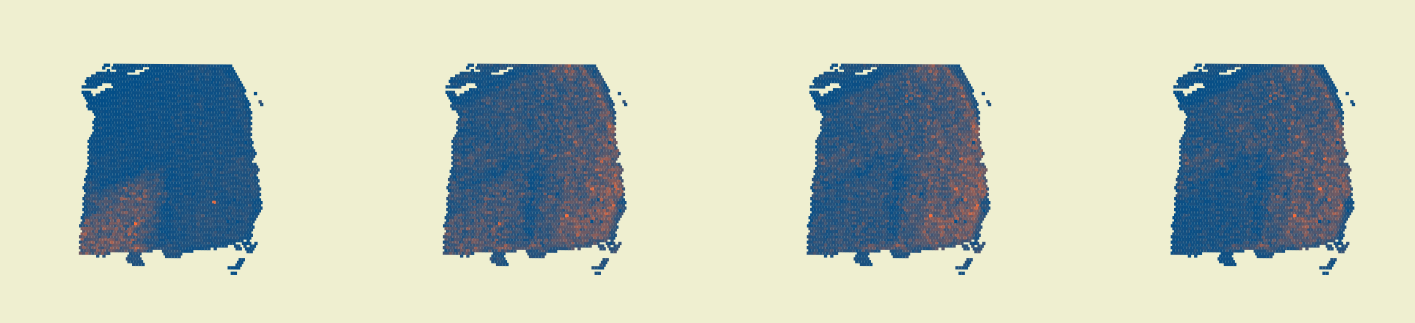

In [314]:
a1 = array_data[get_ids_inside_box(params, [0.0, 1], [0.0, 0.8])]
a1 = a1.mean(0)

a2 = array_data[get_ids_inside_box(params, [0.0, 1], [0.8, 1])]
a2 = a2.mean(0)

a3 = array_data[get_ids_inside_box(params, [1, 2.5], [0.8, 1])]
a3 = a3.mean(0)

a4 = array_data[get_ids_inside_box(params, [1.5, 3], [0, 0.7])]
a4 = a4.mean(0)

_, axs = plt.subplots(1, 4, figsize=(18, 5))
areas = [a1, a2, a3, a4]

for i in range(4):
    a  = areas[i]
    ax = axs[i]
    plot_spatial_scatter(
        scdata, 
        a,  
        ax           = ax,
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square")

plt.savefig("presentazione\\nbin_areas_mean", dpi=1000)

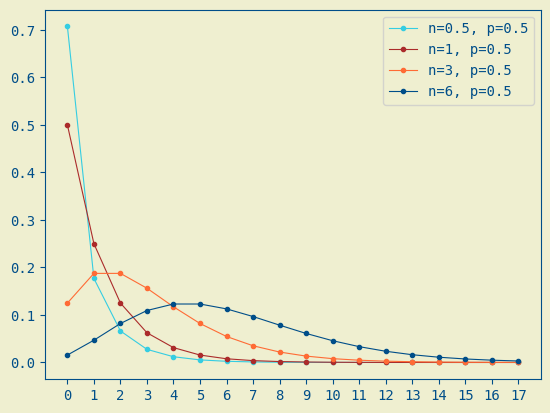

In [311]:
n = [0.5, 1, 3, 6]
p = [0.5]

prms = []
for ni in n:
    for pi in p:
        prms.append((ni, pi))

c1 = "#35cde2"
c2 = "#ab2b2b"

cs = [c1, c2, Or, B]

for i, (n, p) in enumerate(prms):
    x   = np.arange(18)
    pdf = nbinom(n, p).pmf(x)
    plt.plot(
        x, 
        pdf,   
        color  = cs[i],
        marker = "o", 
        ms     = 3, 
        lw     = 0.8, 
        label  = f"n={n}, p={p}")
    
plt.xticks(np.arange(18))
plt.legend()
plt.savefig("bin_neg", dpi=1000)
plt.show()

In [382]:
from sklearn.mixture import GaussianMixture

c = []
for i in range(len(spat_var_genes)):
    data = array_data[i].astype(int)
    bins = np.bincount(data)
    
    if np.any((bins[1:] - bins[:-1]) > 1):
        c.append(i)

c = np.array(c)
c.shape

(244,)

In [386]:
# plot_spatial_scatter(
#     scdata, 
#     data.mean(0),  
#     cmap         = myCMAP, 
#     spines_color = W, 
#     size         = 1.5, 
#     shape        = "square")

k2 = []
for gene_id in c:
    data = array_data[gene_id].astype(int)

    # bins  = np.bincount(data)
    # count = np.arange(np.max(data)+1)
    # plt.bar(count, bins, width=0.8)

    nbin_LL = -negative_log_likelihood(params[:,gene_id], data)
    data    = data.reshape(-1, 1)
    gmm2    = GaussianMixture(n_components=2, random_state=0).fit(data)

    AIC_nbin = 4 - 2*nbin_LL
    AIC_gmm  = gmm2.aic(data)

    if AIC_gmm < AIC_nbin:
        k2.append(gene_id)



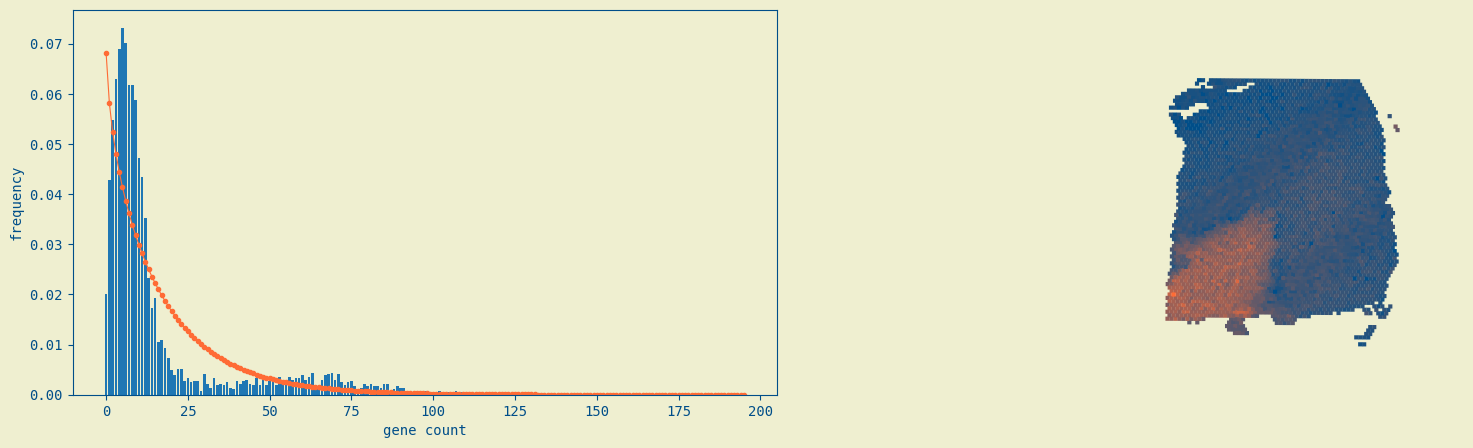

In [439]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

data = array_data[k2[8]].astype(int)

plot_counts_and_scatter(data, (ax1, ax2))

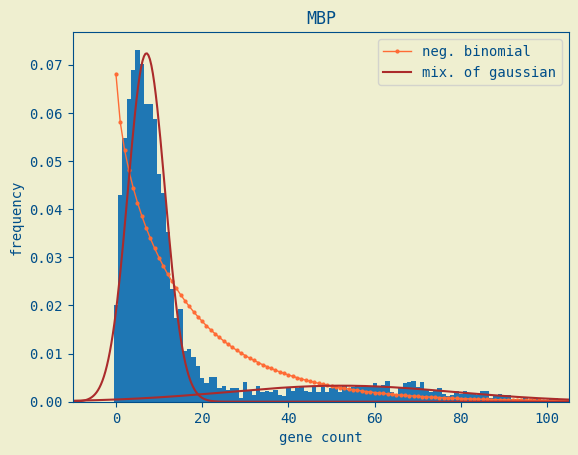

In [458]:
gene_names = scdata.var.index.to_numpy()

gene_name = gene_names[spat_var_genes[k2[8]]]

gdata = array_data[k2[8]].astype(int)

bins  = np.bincount(gdata)/len(gdata)
count = np.arange(np.max(gdata)+1)
plt.bar(count, bins, width=1)

n, p     = fit_nbinom(gdata, iter=10, method="Nelder-Mead")
nbin_pdf = nbinom(n, p).pmf(count)
plt.plot(
    count, 
    nbin_pdf, 
    color  = Or,  
    marker = "o", 
    ms     = 2, 
    lw     = 1, 
    label  = "neg. binomial")

gmm2   = GaussianMixture(n_components=2, random_state=0).fit(gdata.reshape(-1, 1))
m1, m2 = gmm2.means_
v1, v2 = np.sqrt(gmm2.covariances_)
w1, w2 = gmm2.weights_

count = np.linspace(-10,  np.max(gdata)+1, 600)

norm_pdf1 = (scipy.stats.norm(m1, v1).pdf(count)*w1).reshape(-1)
norm_pdf2 = (scipy.stats.norm(m2, v2).pdf(count)*w2).reshape(-1)

plt.plot(count, norm_pdf1, c=c2)
plt.plot(count, norm_pdf2, c=c2, label="mix. of gaussian")
#plt.plot(count, norm_pdf2 + norm_pdf1, c=c2, label="mix. of gaussian")

plt.ylabel("frequency")
plt.xlabel("gene count")
plt.xlim([-10, 105])
plt.title(gene_name)
plt.legend()
plt.savefig("presentazione\\MoG2", dpi=1000)

plt.show()

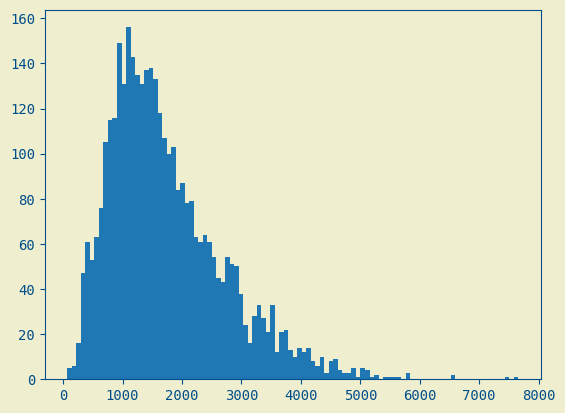

In [693]:
plt.hist(array_data.sum(0), bins=100)
plt.show()

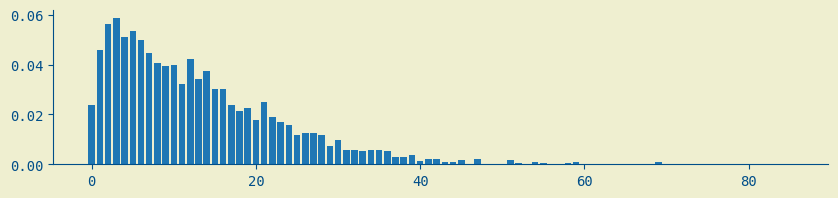

In [473]:
from matplotlib.pyplot import figure
figure(figsize=(10, 2))

gdata = get_gene_data(scdata, 29313).astype(int)
bins  = np.bincount(gdata)/len(gdata)
count = np.arange(np.max(gdata)+1)
plt.bar(count, bins, width=0.8)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.savefig("presentazione\\bar_dist_random", dpi=1000)

plt.show()

In [1280]:
import kneed

def find_knee(x, y, ax=None, hline=None):
    knee_locator = kneed.KneeLocator(x, y, interp_method="polynomial", curve="convex", direction="decreasing")
    knee   = knee_locator.knee  
    knee_y = knee_locator.knee_y 

    if ax:
        ax.plot(x, y, marker="o")
        ax.scatter(knee, knee_y, color=c2, s=100)
        ax.axvline(x=knee, color=c2, linestyle="--", alpha=0.2)
        ax.set_ylabel("BIC")
        ax.set_xlabel("k")
        if hline:
            ax.axhline(y=hline, color="r", linestyle="--")
        
    return knee

def gmm_AIC(gdata, mink=2, maxk=10):

    data = gdata.reshape(-1, 1)
    aics = []

    for i in range(mink, maxk+1):
        gmm     = GaussianMixture(n_components=i, random_state=0).fit(data)
        AIC_gmm = gmm.aic(data)
        aics.append(AIC_gmm)

    return aics

def gmm_BIC(gdata, mink=2, maxk=10):

    data = gdata.reshape(-1, 1)
    bics = []

    for i in range(mink, maxk+1):
        gmm     = GaussianMixture(n_components=i, random_state=0).fit(data)
        BIC_gmm = gmm.bic(data)
        bics.append(BIC_gmm)

    return bics

def filt_data_to_bins(gdata, bins=100):
    bdata = np.histogram(gdata, bins=bins)[0]
    sdata = np.zeros(len(gdata), dtype=int)

    c = 0
    for i in range(bins):
        sdata[c:c+bdata[i]] = i
        c += bdata[i]

    return bdata, sdata

def fit_MoG(gdata, k):
    data = gdata.reshape(-1, 1)
    gmm  = GaussianMixture(n_components=k, random_state=0).fit(data)
    mus  = gmm.means_
    stds = np.sqrt(gmm.covariances_)
    return mus, stds


def plot_hist_and_MoG(gdata, k, ax=None):
    data = gdata.reshape(-1, 1)
    gmm  = GaussianMixture(n_components=k, random_state=0).fit(data)
    mus  = gmm.means_
    stds = np.sqrt(gmm.covariances_)
    weis = gmm.weights_

    rng  = np.linspace(0, gdata.max(), 500)
    for i in range(k):
        m, v, w = mus[i], stds[i], weis[i]
        ax.plot(rng, (norm(m, v).pdf(rng)*w).reshape(-1))
    ax.hist(gdata, bins=100, density=True)

    return mus, stds, weis

def plot_scatter_square(gdata, ax):
    plot_spatial_scatter(
        scdata, 
        gdata, 
        cmap         = myCMAP, 
        spines_color = W, 
        size         = 1.5, 
        shape        = "square",
        ax           = ax)

def smallest_dist(mus, stds):
    idx = np.argmin(mus)
    return mus[idx][0], stds[idx][0][0]



In [1215]:
scdata     = load_data()
smallest   = select_top_spatially_variable_genes(scdata, 3000, 500, 3000)
array_data = scdata.X.toarray().T
np.intersect1d(smallest, spat_var_genes).shape, smallest.shape

c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Workstation\magistrale\algo_ai\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


((939,), (1033,))

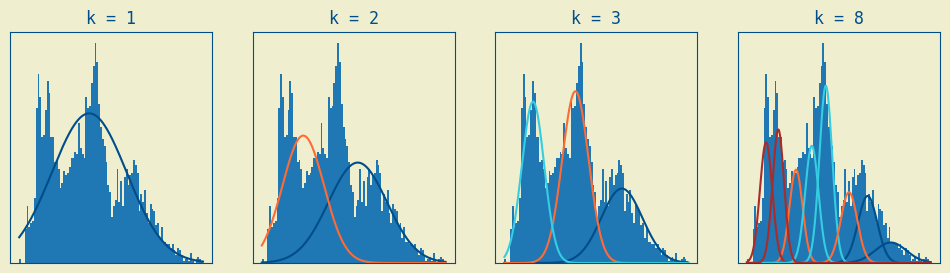

In [1322]:
gene_id = 9831
gdata   = get_gene_data(scdata, gene_id).astype(int)
gdata   = opt_mean_filter_iterated(gdata, 10)

rng     = np.linspace(0, gdata.max(), 500)
data    = gdata.reshape(-1, 1)

_, axs  = plt.subplots(1, 4, figsize=(12, 3))

ks     = [1, 2, 3, 8]
colors = [B, Or, c1, c2]

for i in range(4):
    k    = ks[i]
    ax   = axs[i]
    
    gmm  = GaussianMixture(n_components=k, random_state=0).fit(data)
    mus  = gmm.means_
    stds = np.sqrt(gmm.covariances_)
    weis = gmm.weights_

    ax.hist(gdata, bins=100, density=True)
    ax.set_title(f"k = {k}")
    for j in range(k):
        m, v, w = mus[j], stds[j], weis[j]
        ax.plot(rng, (norm(m, v).pdf(rng)*w).reshape(-1), c=colors[j%4])
    ax.tick_params(
        left        = False, 
        bottom      = False,
        labelleft   = False, 
        labelbottom = False) 
    
plt.savefig("presentazione\\gauss_misxture_multik", dpi=1000)
plt.show()

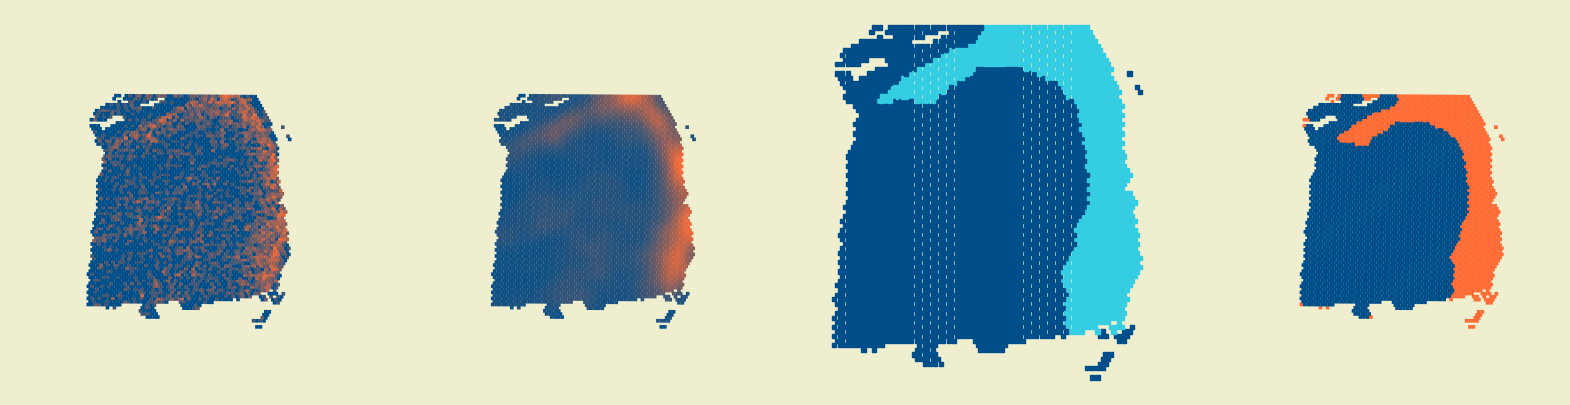

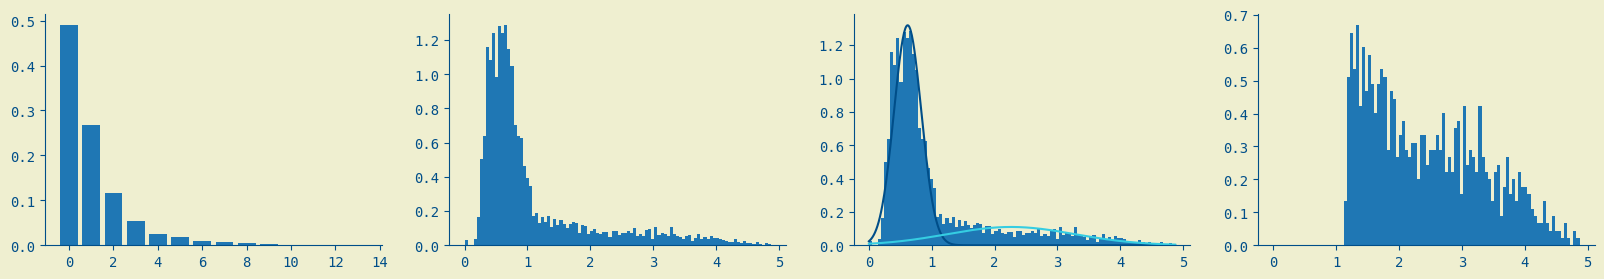

In [1308]:
f1, cs_axs   = plt.subplots(1, 4, figsize=(20, 5))
f2, dist_axs = plt.subplots(1, 4, figsize=(20, 3))

for ax in dist_axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# gene_ids = np.intersect1d(smallest, spat_var_genes)

# gene_id = choice(gene_ids)
# print(gene_id)

gene_id = 3276
gdata   = get_gene_data(scdata, gene_id).astype(int)

### AX 1
plot_scatter_square(np.log(gdata+1), ax=cs_axs[0])

bins  = np.bincount(gdata)/len(gdata)
count = np.arange(np.max(gdata)+1)

dist_axs[0].bar(count, bins)

### AX 2
gdata = opt_mean_filter_iterated(gdata, 10)

plot_scatter_square(gdata, ax=cs_axs[1])
dist_axs[1].hist(gdata, bins=100, density=True)


### AX 3

mink = 1
maxk = 8
x    = np.arange(mink, maxk+1)

bics = gmm_BIC(gdata, mink, maxk)
k    = find_knee(x, bics)

# plot_scatter_square(gdata, ax=cs_axs[2])
# plot_hist_and_MoG(gdata, k, dist_axs[2])

data   = gdata.reshape(-1, 1)
gmm    = GaussianMixture(n_components=k, random_state=0).fit(data)

colors = [B, c1, Or]

mus  = gmm.means_.reshape(-1)
stds = np.sqrt(gmm.covariances_).reshape(-1)
weis = gmm.weights_.reshape(-1)

order = np.argsort(mus)

smus  = mus[order]
sstds = stds[order]
sweis = weis[order]

rng  = np.linspace(0, gdata.max(), 500)
for i in range(k):
    m, v, w = smus[i], sstds[i], sweis[i]
    dist_axs[2].plot(rng, (norm(m, v).pdf(rng)*w).reshape(-1), c=colors[i])
n, b, _ = dist_axs[2].hist(gdata, bins=100, density=True)

labels = gmm.predict(data)

#order = order[order]
clrs   = [colors[order[l]] for l in labels]

cs_axs[2].scatter(index_to_cart[:, 0], index_to_cart[:, 1], marker="s", s=9, c=clrs)
cs_axs[2].set_aspect("equal")
cs_axs[2].axis('off')

### AX 4

mus, stds = fit_MoG(gdata, k)
m, v      = smallest_dist(mus, stds)

#pgdata = expansion_filter_iterated((gdata>(m+1.5*v)).astype(int), 10)

pgdata = expansion_filter_iterated((gdata>1.2).astype(int), 10)


min_label = np.argmin(mus)

plot_scatter_square(pgdata, ax=cs_axs[3])
dist_axs[3].hist(gdata[labels!=min_label], bins=b, density=True)

f1.savefig("presentazione\\phase3_ex3_sc", dpi=1000)
f2.savefig("presentazione\\phase3_ex3_ds", dpi=1000)

# 9831, 3276, 13839

plt.show()

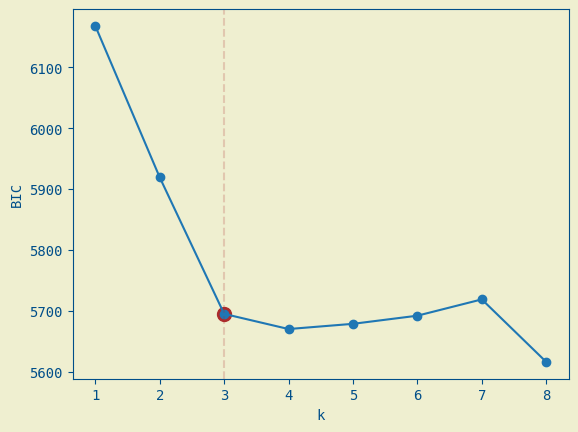

In [1283]:
mink = 1
maxk = 8
x    = np.arange(mink, maxk+1)

bics = gmm_BIC(gdata, mink, maxk)
k    = find_knee(x, bics, plt.gca())
plt.savefig("presentazione\\knee_plot", dpi=1000)

In [ ]:

mink = 1
maxk = 8
x    = np.arange(mink, maxk+1)

gene_ids   = np.intersect1d(smallest, spat_var_genes)
array_data = scdata.X.toarray().T

transformed_gdata = np.zeros((len(gene_ids), len(array_data[0])), dtype=int)

for i in range(len(gene_ids)):

    if i%50==0: print(f"{i}/{len(gene_ids)}")

    gene_id = gene_ids[i]
    gdata   = array_data[gene_id]
    gdata   = opt_mean_filter_iterated(gdata, 10)

    bics = gmm_BIC(gdata, mink, maxk)
    k    = find_knee(x, bics)

    # k = np.argmin(bics)

    mus, stds = fit_MoG(gdata, k)
    m, v      = smallest_dist(mus, stds)

    pgdata = expansion_filter_iterated((gdata>(m+1.5*v)).astype(int), 10)

    transformed_gdata[i] = pgdata

np.save("trasnformed_gdata", transformed_gdata)

0/939
50/939
100/939
150/939
200/939
250/939
300/939
350/939
400/939
450/939
500/939
550/939
600/939
650/939
700/939
750/939
800/939
850/939
900/939


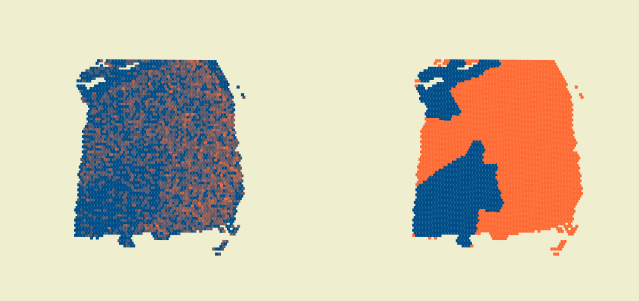

In [1251]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

gene_id = 25354 #choice(num_varspat_genes)

gdata   = array_data[gene_id]

plot_spatial_scatter(
    scdata, 
    np.sqrt(gdata), 
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square",
    ax           = ax1)

gdata   = opt_mean_filter_iterated(max_filter(gdata), 10)

bics = gmm_BIC(gdata, mink, maxk)
k    = find_knee(x, bics)

mus, stds = fit_MoG(gdata, k)
m, v      = smallest_dist(mus, stds)

pgdata = expansion_filter_iterated((gdata>(m+1.8*v)).astype(int), 10)

plot_spatial_scatter(
    scdata, 
    pgdata, 
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square",
    ax           = ax2)

plt.savefig("presentazione\\transf_ex3", dpi=1000)

25354


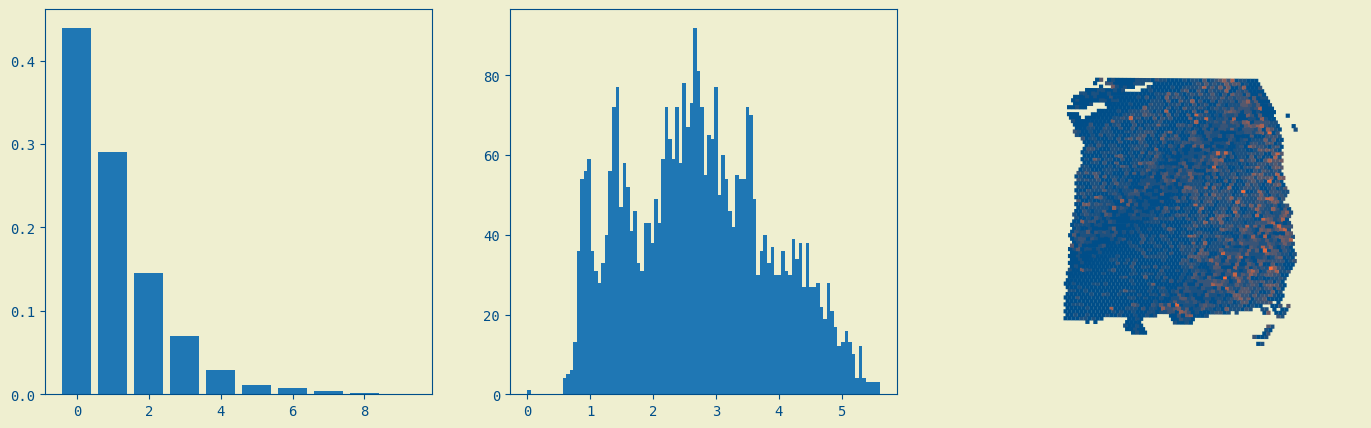

In [1141]:
gdata = get_gene_data(scdata, 29313).astype(int)

gene_id = choice(num_varspat_genes)
gdata   = get_gene_data(scdata, gene_id).astype(int)

print(gene_id)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

bins  = np.bincount(gdata)/len(gdata)
count = np.arange(np.max(gdata)+1)
ax1.bar(count, bins, width=0.8)

plot_spatial_scatter(
    scdata, 
    gdata, 
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square",
    ax=ax3)

gdata = opt_mean_filter_iterated(max_filter(gdata), 10)
ax2.hist(gdata, bins=100)

plt.show()

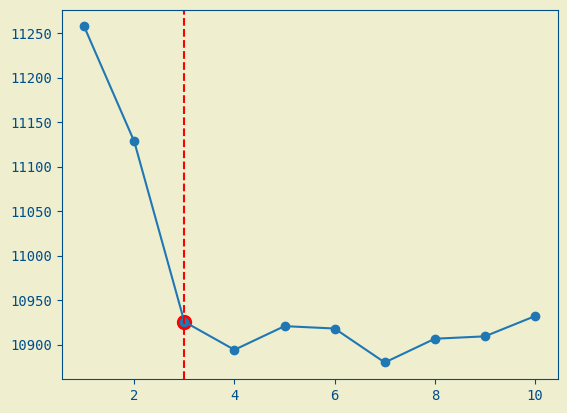

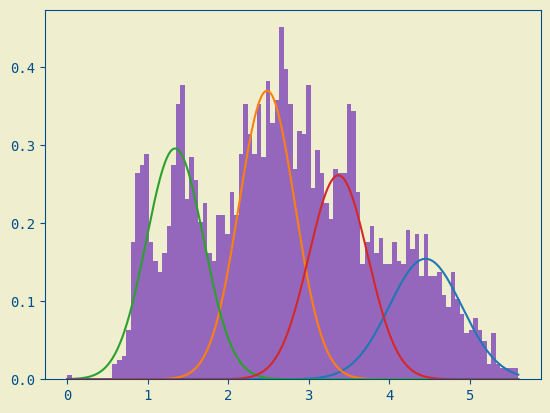

In [1184]:
mink = 1
maxk = 10

aics = gmm_BIC(gdata, mink, maxk)

x = np.arange(mink, mink+len(aics))
y = aics

k = find_knee(x, y, ax=plt.gca())

plt.show()

mus, stds, _ = plot_hist_and_MoG(gdata, 4, ax=plt.gca())

In [1153]:
index_to_cart = np.zeros((len(scdata.obs), 2))
max_row       = scdata.obs['array_row'].max()
for i, ind in enumerate(scdata.obs.index):
    col = scdata.obs['array_col'][ind]
    row = scdata.obs['array_row'][ind]
    index_to_cart[i, 0] = col             * (np.sqrt(3)/2)
    index_to_cart[i, 1] = (max_row - row) * (3/2)

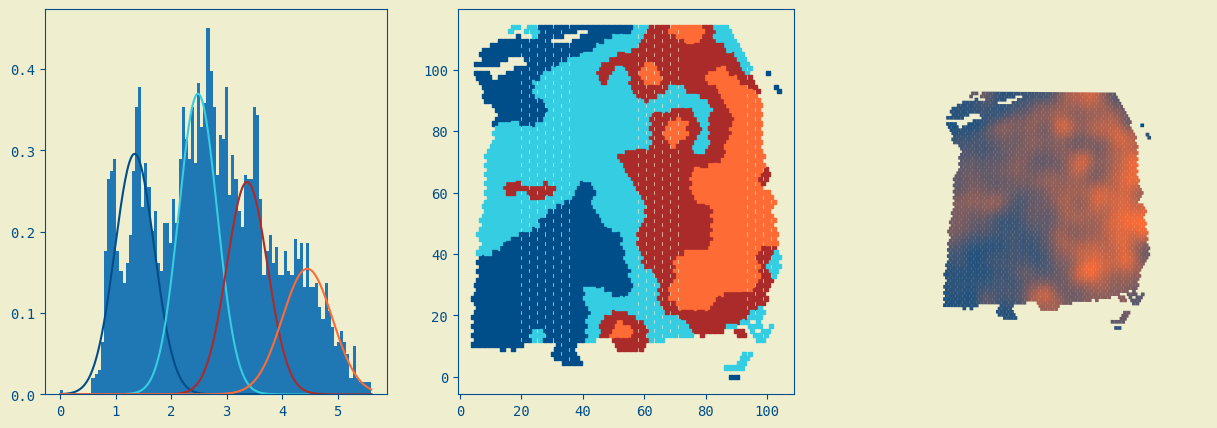

In [1188]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

k = 4

data   = gdata.reshape(-1, 1)
gmm    = GaussianMixture(n_components=k, random_state=0).fit(data)

colors = [B, c1, c2, Or]

mus  = gmm.means_.reshape(-1)
stds = np.sqrt(gmm.covariances_).reshape(-1)
weis = gmm.weights_.reshape(-1)

order = np.argsort(mus)

smus  = mus[order]
sstds = stds[order]
sweis = weis[order]

rng  = np.linspace(0, gdata.max(), 500)
for i in range(k):
    m, v, w = smus[i], sstds[i], sweis[i]
    ax1.plot(rng, (norm(m, v).pdf(rng)*w).reshape(-1), c=colors[i])
ax1.hist(gdata, bins=100, density=True)

labels = gmm.predict(data)

order = order[order]
clrs   = [colors[order[l]] for l in labels]

ax2.scatter(index_to_cart[:, 0], index_to_cart[:, 1], marker="s", s=9, c=clrs)
ax2.set_aspect("equal")

plot_spatial_scatter(
    scdata, 
    gdata, 
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square",
    ax           = ax3)

#plt.savefig("something", dpi=1000)

array([3, 1, 0, 2], dtype=int64)

1.2383775961725751


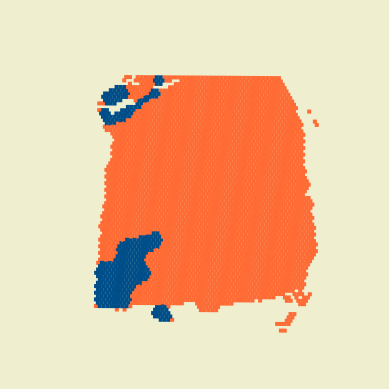

In [1149]:
def smallest_dist(mus, stds):
    idx = np.argmin(mus)
    return mus[idx][0], stds[idx][0][0]

m, v = smallest_dist(mus, stds)
print(m+1.8*v)

plot_spatial_scatter(
    scdata, 
    #expansion_filter_iterated((gdata>0.18).astype(int), 10),  
    expansion_filter_iterated((gdata>(m+1.8*v)).astype(int), 10),  
    #gdata,
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square")

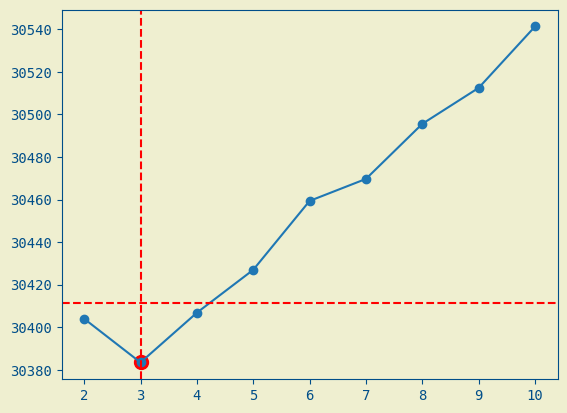

In [1007]:
bins = 100
bdata, sdata = filt_data_to_bins(gdata, 100)

n, p     = fit_nbinom(sdata, 1, "Nelder-Mead")
# AIC_nbin = 2*2 - (-2*negative_log_likelihood((n, p), sdata))
BIC_nbin = 2*np.log(len(sdata)) - (-2*negative_log_likelihood((n, p), sdata))


mink, maxk = 2, 10
aics = gmm_BIC(sdata, mink, maxk)

x = np.arange(mink, mink+len(aics))
y = aics

ax = plt.gca()
k  = find_knee(x, y, ax=ax, hline=BIC_nbin)

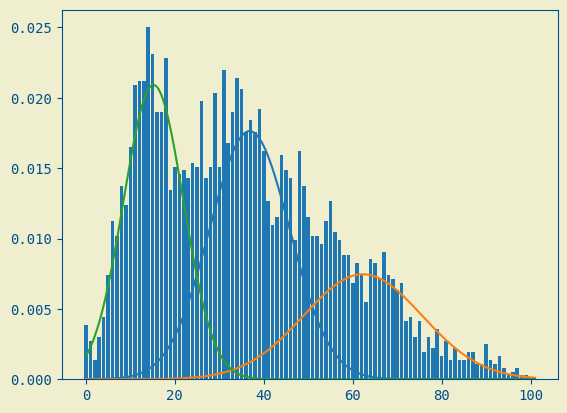

In [980]:
data = sdata.reshape(-1, 1)

K    = k
gmm  = GaussianMixture(n_components=K, random_state=0).fit(data)
mus  = gmm.means_
stds = np.sqrt(gmm.covariances_)
weis = gmm.weights_

rng  = np.linspace(0, bins+1, 500)
for i in range(K):
    m, v, w = mus[i], stds[i], weis[i]
    plt.plot(rng, (norm(m, v).pdf(rng)*w).reshape(-1))

plt.bar(np.arange(bins),  bdata/len(gdata))
plt.show()

(19.112158683079254, 6.468931447071956)

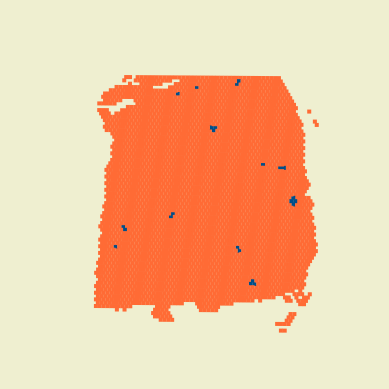

In [861]:
def smallest_dist(mus, stds):
    idx = np.argmin(mus)
    return mus[idx][0], stds[idx][0][0]

m, v = smallest_dist(mus, stds)

plot_spatial_scatter(
    scdata,  
    expansion_filter_iterated((sdata>(m+2*v)).astype(int), 2),  
    cmap         = myCMAP, 
    spines_color = W, 
    size         = 1.5, 
    shape        = "square")

m, v

array([0, 0, 0, ..., 1, 1, 1])